# PCA on UKBB Meshes

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

import pyvista as pv
pv.set_plot_theme("document")

from coma.utils.decomposition import PCAShapeModel3D
from coma.utils.visualise import plot_mesh_pyvista, plot_meshes_pyvista

## Load Dataset

In [2]:
meshes = torch.load('training_meshes.pt')
features = pd.read_csv('training_metadata.csv')

print(meshes.shape)
features.head()

(10441, 642, 3)


,Unnamed: 0,eid,sex,age,structure_volume,brain_volume
0,8809,3820915,0,56,23764,1041180
1,11675,3677460,1,66,22000,1143400
2,9633,4383421,1,63,27148,1369520
3,8374,3069151,0,59,20223,980627
4,14213,1457636,0,50,21183,1386220


In [3]:
template_path = '/vol/biomedic3/bglocker/brainshapes/5026976/T1_first-BrStem_first.vtk'
template = pv.read(template_path)
faces = template.faces.T.reshape(-1, 4)[:, 1:]

## Diagrams

In [39]:
features.sex.values == 0

array([ True, False, False, ...,  True, False,  True])

In [4]:
shape_model = PCAShapeModel3D()
shape_model.fit(meshes)

In [5]:
shape_model_sex_f = PCAShapeModel3D()
shape_model_sex_f.fit(meshes[features.sex.values == 0])

shape_model_sex_m = PCAShapeModel3D()
shape_model_sex_m.fit(meshes[features.sex.values == 1])

In [6]:
age_range = features.age.max() - features.age.min()
min_age = features.age.min()
buckets = 3
bucket_size = age_range // buckets
shape_models = {}

for i in range(buckets):
    lb = min_age + bucket_size * i
    ub = min_age + bucket_size * (i + 1)
    mask = (features.age.values >= lb) & (features.age.values < ub)
    meshes_bucket = meshes[mask]
    shape_models[(lb, ub)] = PCAShapeModel3D()
    shape_models[(lb, ub)].fit(meshes_bucket)

In [41]:
shape_models

{(40, 50): <coma.utils.decomposition.PCAShapeModel3D at 0x7fedfe7860a0>,
 (50, 60): <coma.utils.decomposition.PCAShapeModel3D at 0x7fed5bb3e550>,
 (60, 70): <coma.utils.decomposition.PCAShapeModel3D at 0x7fed5bb3e520>}

In [7]:
def calc_diff_map(shape_model, mean, mode):
    (mode_pos, _) = shape_model.mode(mode, 3)
    diff = np.linalg.norm(mean - mode_pos, axis=1)
    return diff, mode_pos

In [8]:
def calc_diff_maps(modes, models, mean):
    n_models = len(models)
    diff_maps = []
    modes_list = []

    for n_model, model in enumerate(models):
        for mode in range(0, modes):
            diff, mode_pos = calc_diff_map(model, model.mean, mode)
            diff_maps.append(np.expand_dims(diff, 0))
            modes_list.append(np.expand_dims(mode_pos, 0))

    return np.concatenate(diff_maps, axis=0), np.concatenate(modes_list, axis=0)

In [9]:
modes = 5
models = [shape_model, shape_model_sex_m, shape_model_sex_f, *shape_models.values()]
n_models = len(models)
diff_maps2, modes_arr = calc_diff_maps(
    modes=modes,
    models=models,
    mean=shape_model.mean,
)

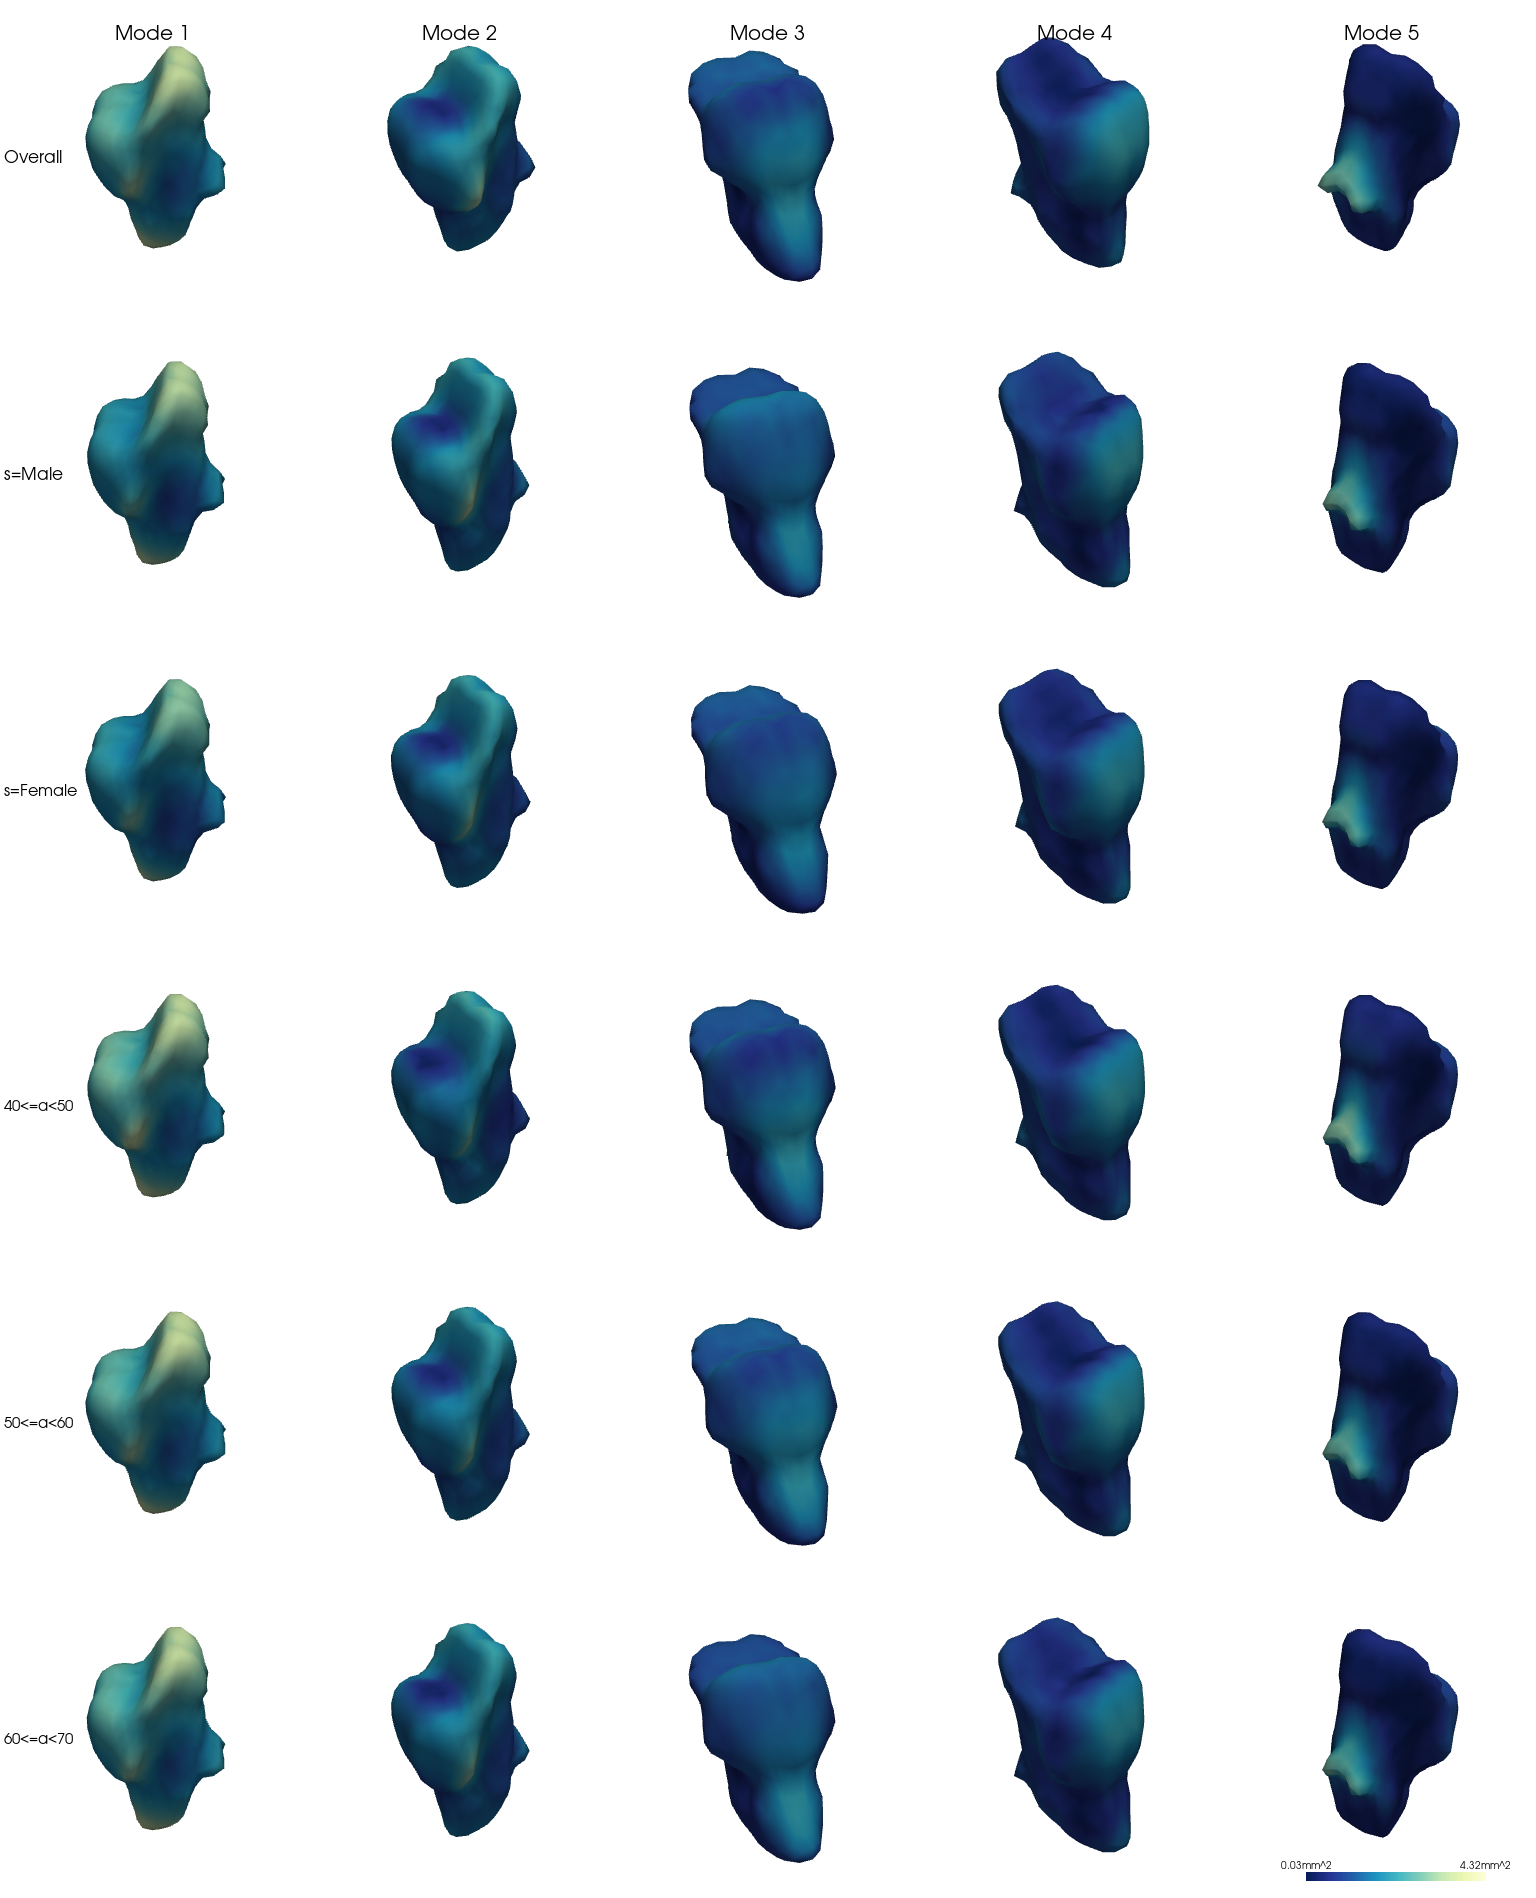

[(198.5243569356537, -84.46628181740485, 305.14345382311495),
 (10.211175118036316, -272.77946363502224, 116.83027200549756),
 (0.0, 0.0, 1.0)]

In [47]:
template_copy = template.copy()
template_copy.points = shape_model.mean

plots = modes * n_models
width = 768 * 2
height = int(width / (1.618 / 2))

# rotations = [
#     (0, 0, 240), (0, -10, 80), (45, 0, -45), (40, 0, -45),
#     (0, 0, 90), (0, 0, 50), (0, 0, 50)
# ]
rotations = [
    (0, 0, 220), (0, 0, 250), (45, 0, -20), (20, 0, 10), (-10, 0, 95),
    (0, 0, 270), (-5, 0, -45), (0, 0, 10), (-10, 0, 95), (0, 0, 50),
]
rotations = [*rotations[:modes]] * n_models
assert len(rotations) == plots

plotter = pv.Plotter(
    shape=(n_models, modes),
    window_size=(width, height),
    border=False,
    lighting='light_kit',
    off_screen=True,
    notebook=True,
)

polydatas = []
for i in range(plots):
    template_copy = template.copy()
    template_copy.points = shape_model.mean + modes_arr[i]
    polydatas.append(template_copy)

titles = [f'Mode {n + 1}' for n in range(modes)] + [''] * modes * (n_models - 1)

plot_meshes_pyvista(
    plotter,
    polydatas,
    rotations=rotations,
    vertexcolors=diff_maps2,
    vertexscalar='distance',
    mesh_kwargs=dict(
        smooth_shading=True
    ),
    scalar_bar_idx=plots-1,
    titles=titles,
#     cmap='jet',
    # cmap='Blues_r',
    title_kwargs=dict(
        font_size=8,
    ),
    scalar_bar_kwargs=dict(
        label_font_size=10,
        position_x=0.85,
        title_font_size=10,
        shadow=True,
        n_labels=2,
        fmt='%.2fmm^2',
    ),
)

row_titles = ['Overall  ', 's=Male  ', 's=Female  ', '40<=a<50  ', '50<=a<60  ', '60<=a<70  ']
assert len(row_titles) == n_models

for i in range(len(row_titles)):
    plotter.subplot(i, 0)
    actor = plotter.add_text(row_titles[i], position='left_edge', font_size=8)

plotter.show(screenshot='shape_modes.png')